## import modules

In [38]:
# Import basic modules
# More modules will be imported before the corresponding function
# import logging # logger = logging.getLogger(__name__)
import math
import os
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") # Ignore some annoying warnings
from datetime import datetime

# Import module for EMD decomposition
# It is the EMD-signal module with different name to import
from PyEMD import EMD,EEMD,CEEMDAN,Visualisation #For module 'PyEMD', please use 'pip install EMD-signal' instead.

# Import modules for LSTM prediciton
# Sklearn
from sklearn.preprocessing import MinMaxScaler # Normalization
from sklearn.metrics import r2_score # R2
from sklearn.metrics import mean_squared_error # MSE
from sklearn.metrics import mean_absolute_error # MAE
from sklearn.metrics import mean_absolute_percentage_error # MAPE


# Statistical tests
from statsmodels.tsa.stattools import adfuller # adf_test
from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test # LB_test
from statsmodels.stats.stattools import jarque_bera as jb_test # JB_test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # plot_acf_pacf

from xgboost import XGBClassifier

In [2]:
#import bitcoin one-minute price series in 2021 Feb
data = pd.read_csv('bit1m.csv')
data = data[['Close']]

In [3]:
data = data[44640:84882]

In [4]:
#data['date'] = data.index
data.index = range(len(data))
data

,Close
0,33037.90
1,33039.07
2,32883.16
3,32864.46
4,32869.04
...,...
40237,45035.99
40238,45023.35
40239,45063.42
40240,45135.66


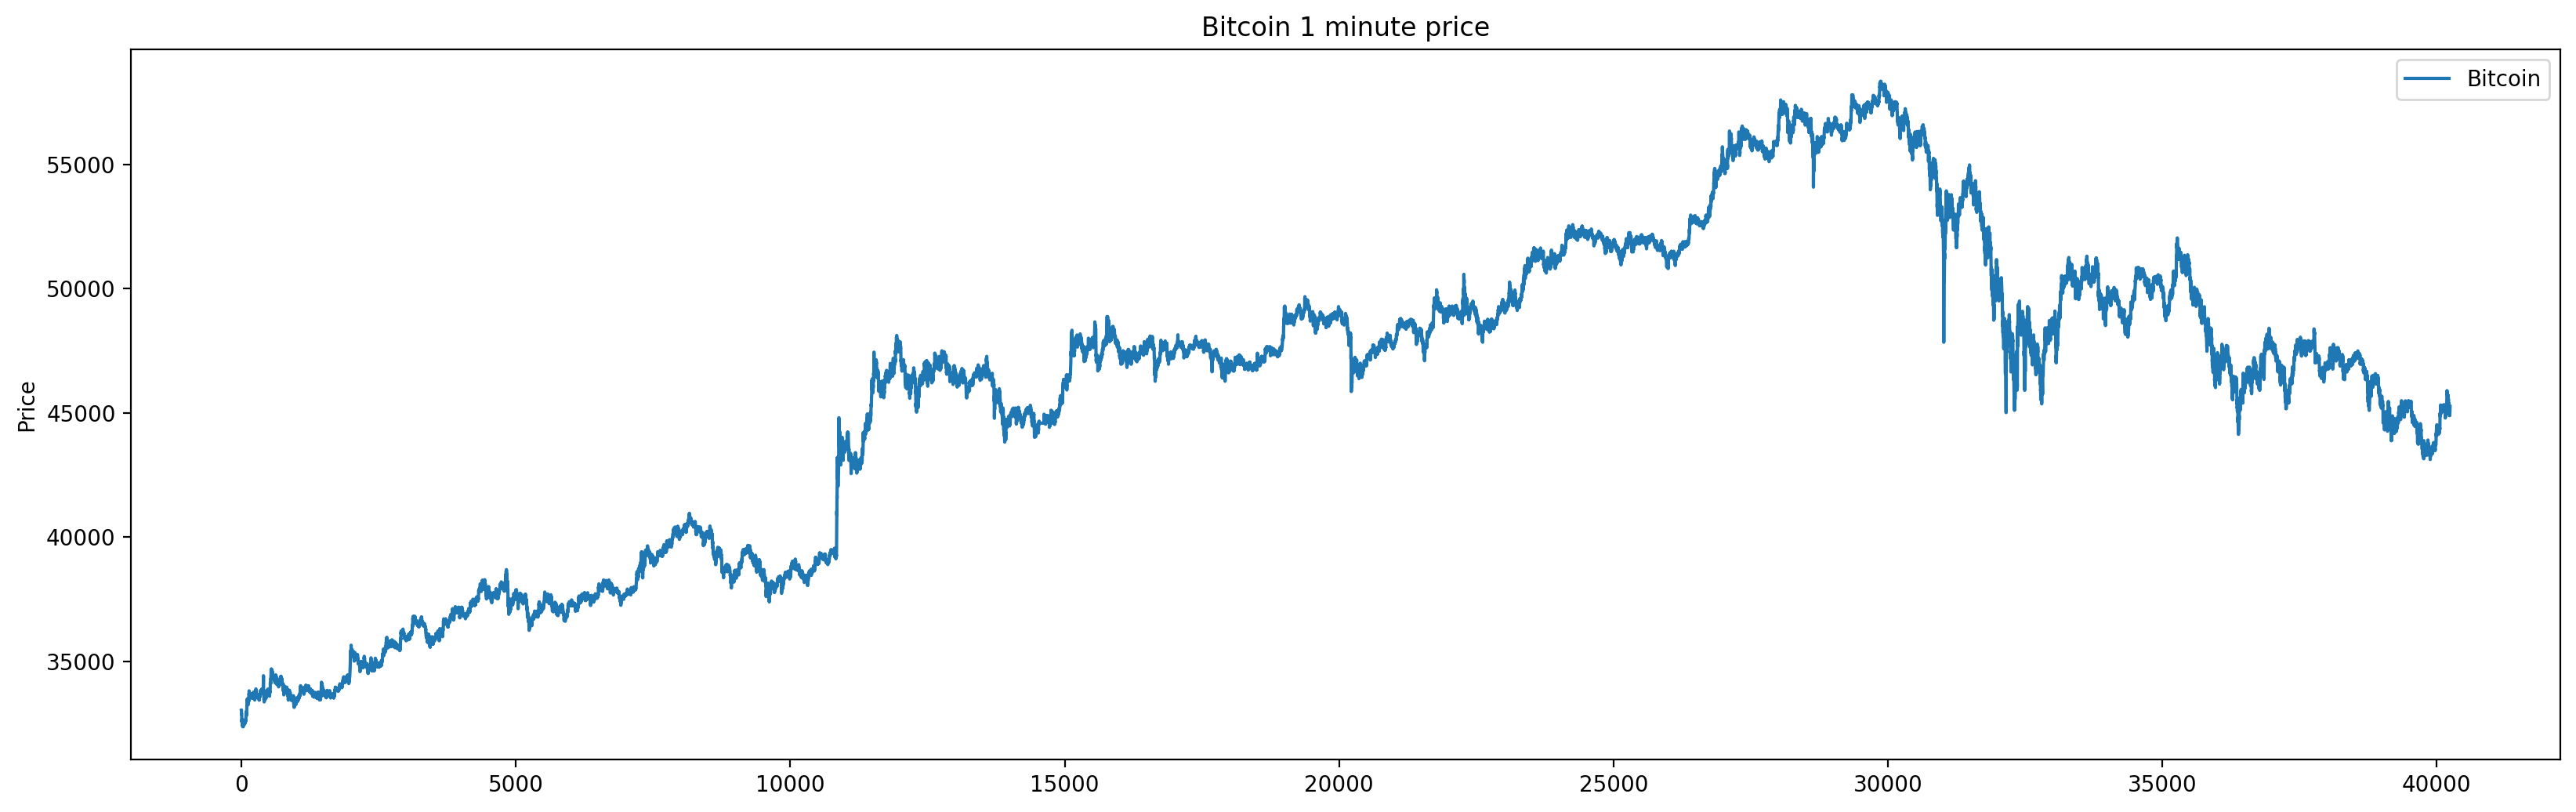

In [105]:
#plot the price series
plt.figure(figsize=(20,6),dpi=200)
plt.title('Bitcoin 1 minute price')
plt.plot(data['Close'],label = 'Bitcoin')
plt.ylabel('Price')
plt.legend()
plt.savefig("./1minbitcoin.jpg")
plt.show()

In [8]:
SERIES = pd.Series(data['Close'].values)

# VMD

In [9]:
import fathon
from fathon import fathonUtils as fu

In [10]:
# Use DFA to calculate the alpha of a time series
def calculate_H(array):
    a = fu.toAggregated(array)
    pydfa = fathon.DFA(a)
    wins = fu.linRangeByStep(4,16)
    n,F = pydfa.computeFlucVec(wins)
    H,H_intercept = pydfa.fitFlucVec()
    return H

In [11]:
# set a value according to the alpha of the original price series for later use
def J_number(num):
    if num <= 0.75:
        J = 1
    elif num> 0.75 and num <= 1.0:
        J = 2
    elif num > 1 and num <= 1.5:
        J = 3
    else:
        J = 4
    return J

In [12]:
#calculate the K
#details are in the paper
def K_num(series,J):
    K = 1
    num = 0
    while (num < 20):
        num = 0
        vmf_imfs = vmd_decom(series,K,draw=False)
        for i in vmf_imfs.columns:
            if calculate_H(vmf_imfs[i]) >= 0.75:
                num = num +1
        if num > J:
                return K-1
        K = K + 1
    #the Max K
    #K = K -1
    #return K

In [13]:
# VMD # There are some problems in this module
# -------------------------------
#use VMD to decompose data and plots the results
def vmd_decom(series,K,draw = False):
    from vmdpy import VMD  
    # VMD parameters
    alpha = 2000       # moderate bandwidth constraint  
    tau = 0.           # noise-tolerance (no strict fidelity enforcement)  
    DC = 0             # no DC part imposed  
    init = 1           # initialize omegas uniformly  
    tol = 1e-7         

    # VMD 
    imfs_vmd, imfs_hat, omega = VMD(series, alpha, tau, K, DC, init, tol)  
    imfs_num = np.shape(imfs_vmd)[0]
    
    if draw:
        # Plot original data
        fig = plt.figure(figsize=(16,2*imfs_num))
        plt.subplot(1+imfs_num, 1, 1 )
        plt.plot(series, color='#0070C0') #F27F19 orange #0070C0 blue
        plt.ylabel('VMD Original data')
    
        # Plot IMFs
        for i in range(imfs_num):
            plt.subplot(1 + imfs_num,1,2 + i)
            plt.plot(imfs_vmd[i, :], color='#F27F19')
            plt.ylabel('VMD-IMF'+str(i))
            
        plt.show()
    
    # Save data
    imfs_df = pd.DataFrame(imfs_vmd.T)
    imfs_df.columns = ['imf'+str(i) for i in range(imfs_num)]

    return imfs_df # pd.DataFrame

In [30]:
#use VMD-DFA to reconstrcut data
def recon_vmd(series):
    alpha0 = calculate_H(series)
    J = J_number(alpha0)
    K = K_num(series,J)
    imfs = vmd_decom(series,K)
    recon_data = imfs.iloc[:,:J].sum(axis = 1)
    
    #Add missing values by inserting the same value at the beginning
    if len(series) > len(recon_data):
        recon_data = list(recon_data)
        recon_data.insert(0,recon_data[0])
        
    return np.array(recon_data)

In [142]:
#use VMD-EMD-DFA to reconstruct data
def revon_vmd_emd(series):
    decom = EMD()
    num = decom(series).shape[0]
    vmf_imfs = vmd_decom(series,num,draw=False)
    col_num = []
    no = 0
    for j in vmf_imfs.columns:
        if calculate_H(vmf_imfs[j]) >= 0.75:
            col_num.append(no)
        no = no+1
    reconstructed_data = vmf_imfs.iloc[:,col_num].sum(axis = 1)
    
    #Add missing values by inserting the same value at the beginning
    if len(series) > len(reconstructed_data):
        reconstructed_data = list(reconstructed_data)
        reconstructed_data.insert(0,reconstructed_data[0])
    
    return reconstructed_data

# emd function

In [16]:
# EMD decomposition
# -------------------------------
# Decompose adaptively and plot function
# Residue is named the last IMF
# plot the results of applying EMD or CEEMDAN
def emd_decom(series,MODE,trials=10,draw=False): 
    # Check input
    series = series.values

    # Initialization
    print('%s decomposition is running.'%str.upper(MODE))
    if MODE == 'emd':decom = EMD()
    elif MODE == 'eemd':decom = EEMD()
    elif MODE == 'ceemdan':decom = CEEMDAN()
        
    # Decompose
    decom.trials = trials # Number of the white noise input
    imfs_emd = decom(series)
    imfs_num = np.shape(imfs_emd)[0]

    if draw:
        # Plot original data
        series_index = range(len(series))
        fig = plt.figure(figsize=(16,2*imfs_num))
        plt.subplot(1+imfs_num, 1, 1 )
        plt.plot(series_index, series, color='#0070C0') #F27F19 orange #0070C0 blue
        plt.ylabel('Original data')
        
        
        # Plot IMFs
        for i in range(imfs_num):
            plt.subplot(1 + imfs_num,1,2 + i)
            plt.plot(series_index, imfs_emd[i, :], color='#F27F19')
            plt.ylabel(str.upper(MODE)+'-IMF'+str(i))
    
    imfs_df = pd.DataFrame(imfs_emd.T)
    imfs_df.columns = ['imf'+str(i) for i in range(imfs_num)]

    return imfs_df # pd.DataFrame

In [17]:
# use EMD or CEEMDAN to decompose data and remove noise
# finally, reconstrcut data by summing the remaining modes
from PyEMD.checks import whitenoise_check
def emd_denoise(mode,series):
    if mode == 'emd':
        decom = EMD()
    elif mode == 'eemd':
        decom = EEMD()
    elif mode == 'ceemdan':
        decom = CEEMDAN()
    imfs = decom(series)
    significant_imfs = whitenoise_check(imfs,alpha = 0.95)
    denoised_data = np.array([0]*len(series))
    print(significant_imfs)
    for i in significant_imfs:
        if significant_imfs[i] ==1:
            denoised_data = denoised_data+imfs[i-1]
    return denoised_data

# plot denoised data

In [106]:
data.shape[0]-num

8049

In [19]:
#the data number of train set
num = int(data.shape[0]*0.8)
print(num)

32193


## EMD

In [26]:
# use EMD to reconstruct the price series in train set
start = time.time()
emd_data = emd_denoise('emd',SERIES[:num].values)
end = time.time()
emd_time = end - start
# the running time of EMD in train set
print(emd_time)

{1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1}
6.024479389190674


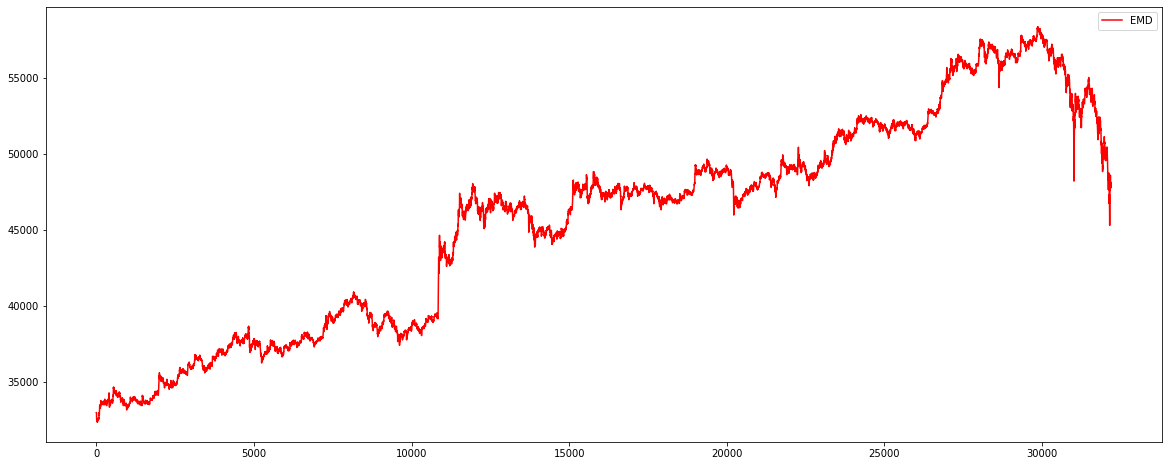

In [24]:
#reconstructed data with EMD
plt.figure(figsize = (20,8))
plt.plot(emd_data,color = 'red' , label = 'EMD')
#plt.plot(SERIES[:40000],color = 'blue' , label = 'original data')
plt.legend()

## CEEMDAN

In [27]:
# use CEEMDAN to reconstruct the price series in train set
start = time.time()
ceemdan_data = emd_denoise('ceemdan',SERIES[:num].values)
end = time.time()
ceemdan_time = end - start
# the running time of CEEMDAN in train set
print(ceemdan_time)

{1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1}
451.0556204319


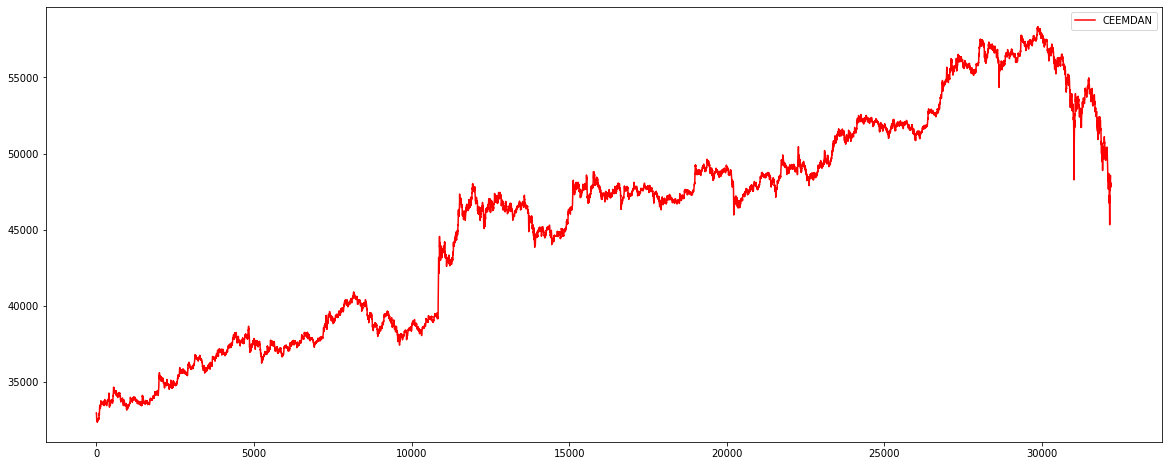

In [28]:
#reconstructed data with CEEMDAN
plt.figure(figsize = (20,8))
plt.plot(ceemdan_data,color = 'red' , label = 'CEEMDAN')
#plt.plot(SERIES[:40000],color = 'blue' , label = 'original data')
plt.legend()

## VMD-DFA

In [32]:
# use VMD-DFA to reconstruct the price series in train set
start = time.time()
vmd_data = recon_vmd(SERIES[:num].values)
end = time.time()
vmd_time = end - start
# the running time of VMD-DFA in train set
print(vmd_time)

18.760802268981934


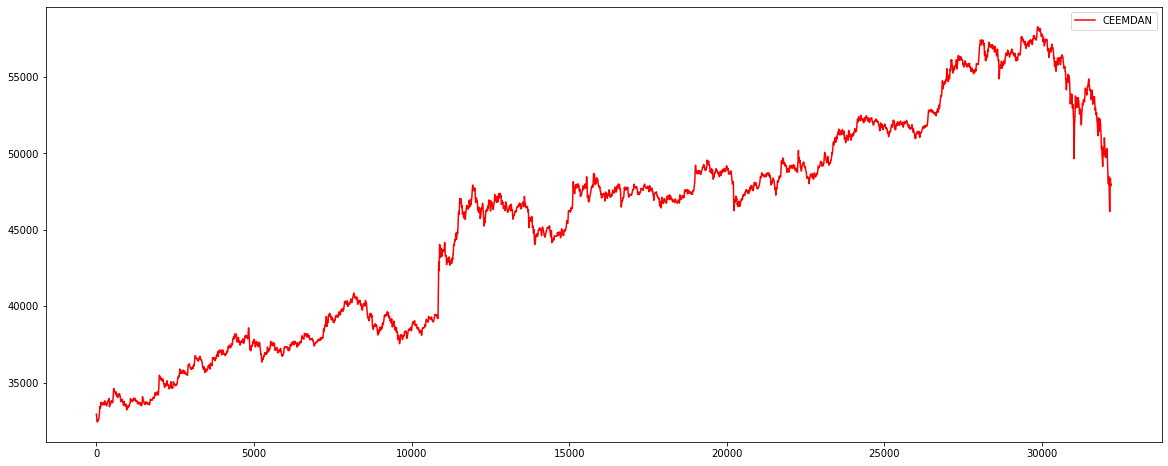

In [33]:
#reconstructed data with VMD-DFA
plt.figure(figsize = (20,8))
plt.plot(vmd_data,color = 'red' , label = 'CEEMDAN')
#plt.plot(SERIES[:40000],color = 'blue' , label = 'original data')
plt.legend()

## VMD-EMD-DFA

In [140]:
vmd_emd_data

0        33006.936398
1        32988.380867
2        32949.547072
3        32892.874746
4        32822.319421
             ...     
32187    47814.509273
32188    47865.606367
32189    47953.693748
32190    48044.496099
32191    48099.471399
Length: 32192, dtype: float64

In [143]:
# use VMD-EMD-DFA to reconstruct the price series in train set
start = time.time()
vmd_emd_data = revon_vmd_emd(SERIES[:num].values)
end = time.time()
vmd_emd_time = end - start
# the running time of VMD-EMD-DFA in train set
print(vmd_emd_time)

37.6316819190979


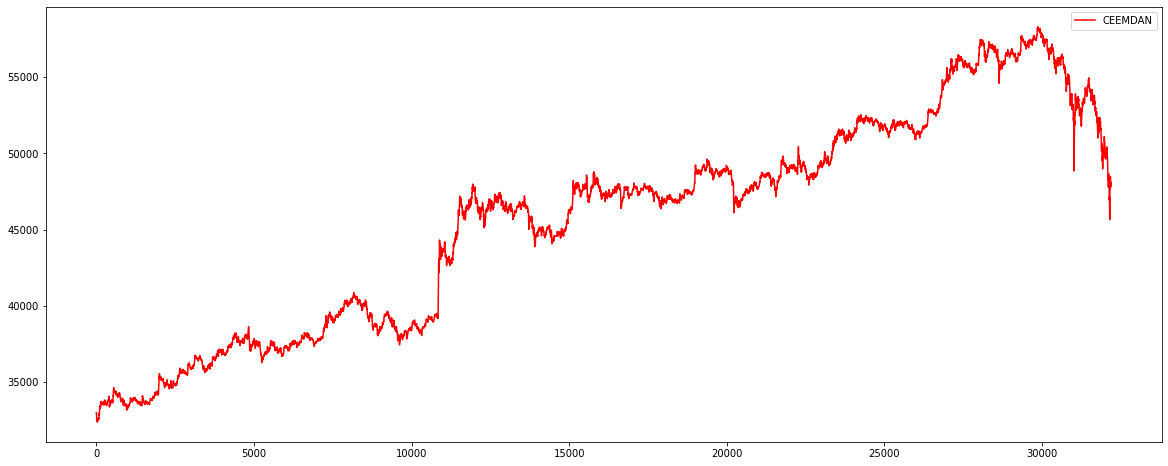

In [147]:
#reconstructed data with VMD-EMD-DFA
plt.figure(figsize = (20,8))
plt.plot(vmd_emd_data,color = 'red' , label = 'CEEMDAN')
#plt.plot(SERIES[:40000],color = 'blue' , label = 'original data')
plt.legend()

# SVC

In [39]:
from sklearn.metrics import f1_score

In [40]:
denoise_df = data[['Close']]

In [41]:
# use the original price series to calculate the log returns
denoise_df['log_ret'] = np.log(denoise_df.iloc[:,0]).diff()

In [42]:
# delete the first row, which contains missing values
denoise_df = denoise_df.iloc[1:,:]
denoise_df.index = range(len(denoise_df))

In [43]:
denoise_df

,Close,log_ret
0,33039.07,0.000035
1,32883.16,-0.004730
2,32864.46,-0.000569
3,32869.04,0.000139
4,32760.03,-0.003322
...,...,...
40236,45035.99,0.002443
40237,45023.35,-0.000281
40238,45063.42,0.000890
40239,45135.66,0.001602


In [44]:
# give the statistical properties of the log returns
stas = denoise_df['log_ret'][:num].describe()
print(stas)

count    32193.000000
mean         0.000012
std          0.001467
min         -0.043556
25%         -0.000682
50%          0.000019
75%          0.000706
max          0.028416
Name: log_ret, dtype: float64


In [69]:
range_list = np.linspace(stas[3]/5, stas[7]/5, num=50,dtype=float)

(array([1.000e+00, 4.000e+00, 8.000e+00, 2.000e+00, 2.000e+00, 5.000e+00,
        5.000e+00, 8.000e+00, 1.300e+01, 7.000e+00, 2.000e+01, 2.800e+01,
        2.400e+01, 3.600e+01, 5.800e+01, 5.300e+01, 7.300e+01, 1.090e+02,
        1.290e+02, 1.860e+02, 2.550e+02, 3.270e+02, 5.230e+02, 7.230e+02,
        1.068e+03, 1.445e+03, 2.062e+03, 2.874e+03, 3.292e+03, 3.807e+03,
        3.749e+03, 3.069e+03, 2.417e+03, 1.656e+03, 1.175e+03, 8.200e+02,
        5.890e+02, 4.210e+02, 2.620e+02, 2.040e+02, 1.510e+02, 1.110e+02,
        7.600e+01, 6.300e+01, 6.000e+01, 3.500e+01, 2.800e+01, 1.800e+01,
        1.900e+01]),
 array([-0.0087112 , -0.00841743, -0.00812367, -0.00782991, -0.00753614,
        -0.00724238, -0.00694861, -0.00665485, -0.00636108, -0.00606732,
        -0.00577355, -0.00547979, -0.00518602, -0.00489226, -0.0045985 ,
        -0.00430473, -0.00401097, -0.0037172 , -0.00342344, -0.00312967,
        -0.00283591, -0.00254214, -0.00224838, -0.00195461, -0.00166085,
        -0.00136709, -

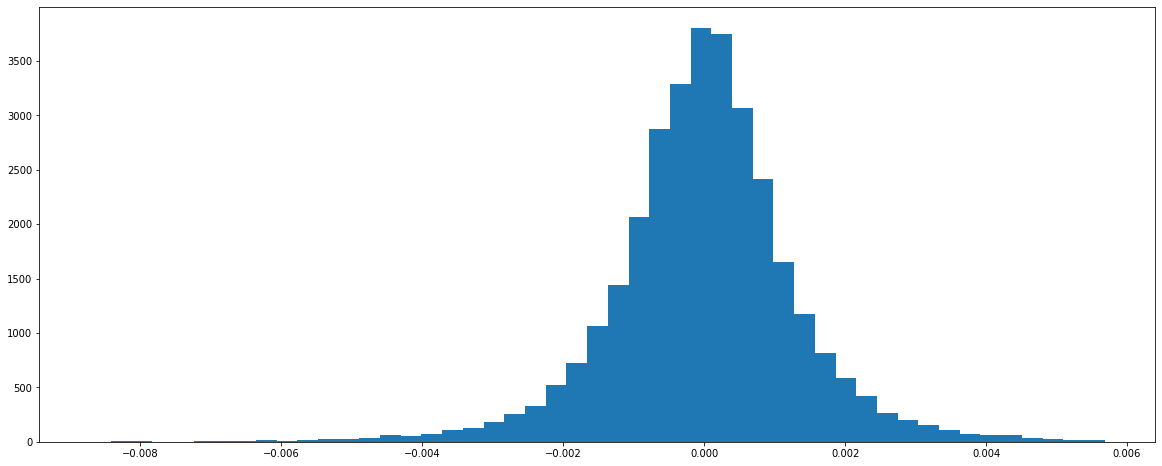

In [70]:
#plot the histogram of log returns
plt.figure(figsize = (20,8))
plt.hist(denoise_df['log_ret'][:num],bins = range_list)

# svc plot

In [45]:
# add labels 
def judge_type(x,threshold):
    if x > threshold :
        label = 0
    elif x< -threshold:
        label = 1
    else :
        label = 2
    return label

In [57]:
# Set the maximum threshold to 60% of the highest log returns
def find_threshold(dataset,percentage=0.6):
    stas = denoise_df['log_ret'].describe()
    return stas[7]*percentage

In [51]:
# plot the f1-scores of the model trained by original data and the model trained by the denoised data
def plot_f1(lst1,lst2,threshold_range,plot_num):
    index = np.linspace(0, threshold_range, num=plot_num,dtype=float)
    plt.figure(figsize = (20,8))
    plt.plot(index,lst1,label = 'original data')
    plt.plot(index,lst2,label = 'denoised data')
    plt.legend()

In [68]:
# calculate the f1-scores of the model trained by original data and the model trained by the denoised data
# with different thresholds
def calculate_f1(dataset,recon_data,threshold,train_num):
    de_df = data[['Close']]
    de_df['reconstructed'] = pd.DataFrame(recon_data)
    de_df['log_ret'] = np.log(de_df.iloc[:,0]).diff()
    de_df['re_log_ret'] = np.log(de_df.iloc[:,1]).diff()
    
    de_df = de_df.iloc[1:,:]
    de_df.index = range(len(de_df))
    
    de_df['label'] = de_df['log_ret'].apply(lambda x : judge_type(x,threshold))
    
    X_train1 = de_df['log_ret'][:train_num-2]
    X_train1  = pd.array(X_train1)
    X_train1  = X_train1.reshape(X_train1.shape[0],1)
    Y_train1 = de_df['label'][1:train_num-1]
    
    X_train2 = de_df['re_log_ret'][:train_num-2]
    X_train2  = pd.array(X_train2)
    X_train2  = X_train2.reshape(X_train2.shape[0],1)
    Y_train2 = Y_train1
    
    X_test = de_df['log_ret'][train_num-2:-1]
    X_test  = pd.array(X_test)
    X_test  = X_test.reshape(X_test.shape[0],1)
    Y_test = de_df['label'][train_num-1:]
    
    #model 1 
    classifier = XGBClassifier()
    model = classifier.fit(X_train1,Y_train1)
    Y_pred = model.predict(X_test)
    f1_1 = f1_score(Y_test,Y_pred,average='weighted')

    #model 2
    classifier = XGBClassifier()
    model = classifier.fit(X_train2,Y_train2)
    Y_pred = model.predict(X_test)
    f1_2 = f1_score(Y_test,Y_pred,average='weighted')

    return f1_1,f1_2

In [58]:
threshold_range = find_threshold(denoise_df)

In [59]:
threshold_range

0.017049788038686484

In [60]:
# set 50 thresholds
pred_range = np.linspace(0, threshold_range, num=50,dtype=float)

In [61]:
pred_range

array([0.        , 0.00034795, 0.00069591, 0.00104386, 0.00139182,
       0.00173977, 0.00208773, 0.00243568, 0.00278364, 0.00313159,
       0.00347955, 0.0038275 , 0.00417546, 0.00452341, 0.00487137,
       0.00521932, 0.00556728, 0.00591523, 0.00626319, 0.00661114,
       0.0069591 , 0.00730705, 0.00765501, 0.00800296, 0.00835092,
       0.00869887, 0.00904683, 0.00939478, 0.00974274, 0.01009069,
       0.01043865, 0.0107866 , 0.01113456, 0.01148251, 0.01183047,
       0.01217842, 0.01252637, 0.01287433, 0.01322228, 0.01357024,
       0.01391819, 0.01426615, 0.0146141 , 0.01496206, 0.01531001,
       0.01565797, 0.01600592, 0.01635388, 0.01670183, 0.01704979])

# EMD Classification

In [76]:
#the f1-scores line of the model trained by original data and the model trained by the EMD denoised data
emd_lst1 = []
emd_lst2 = []
count = 0
for i in pred_range:
    print(count)
    a,b = calculate_f1(data,emd_data,i,num)
    emd_lst1.append(a)
    emd_lst2.append(b)
    count = count + 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


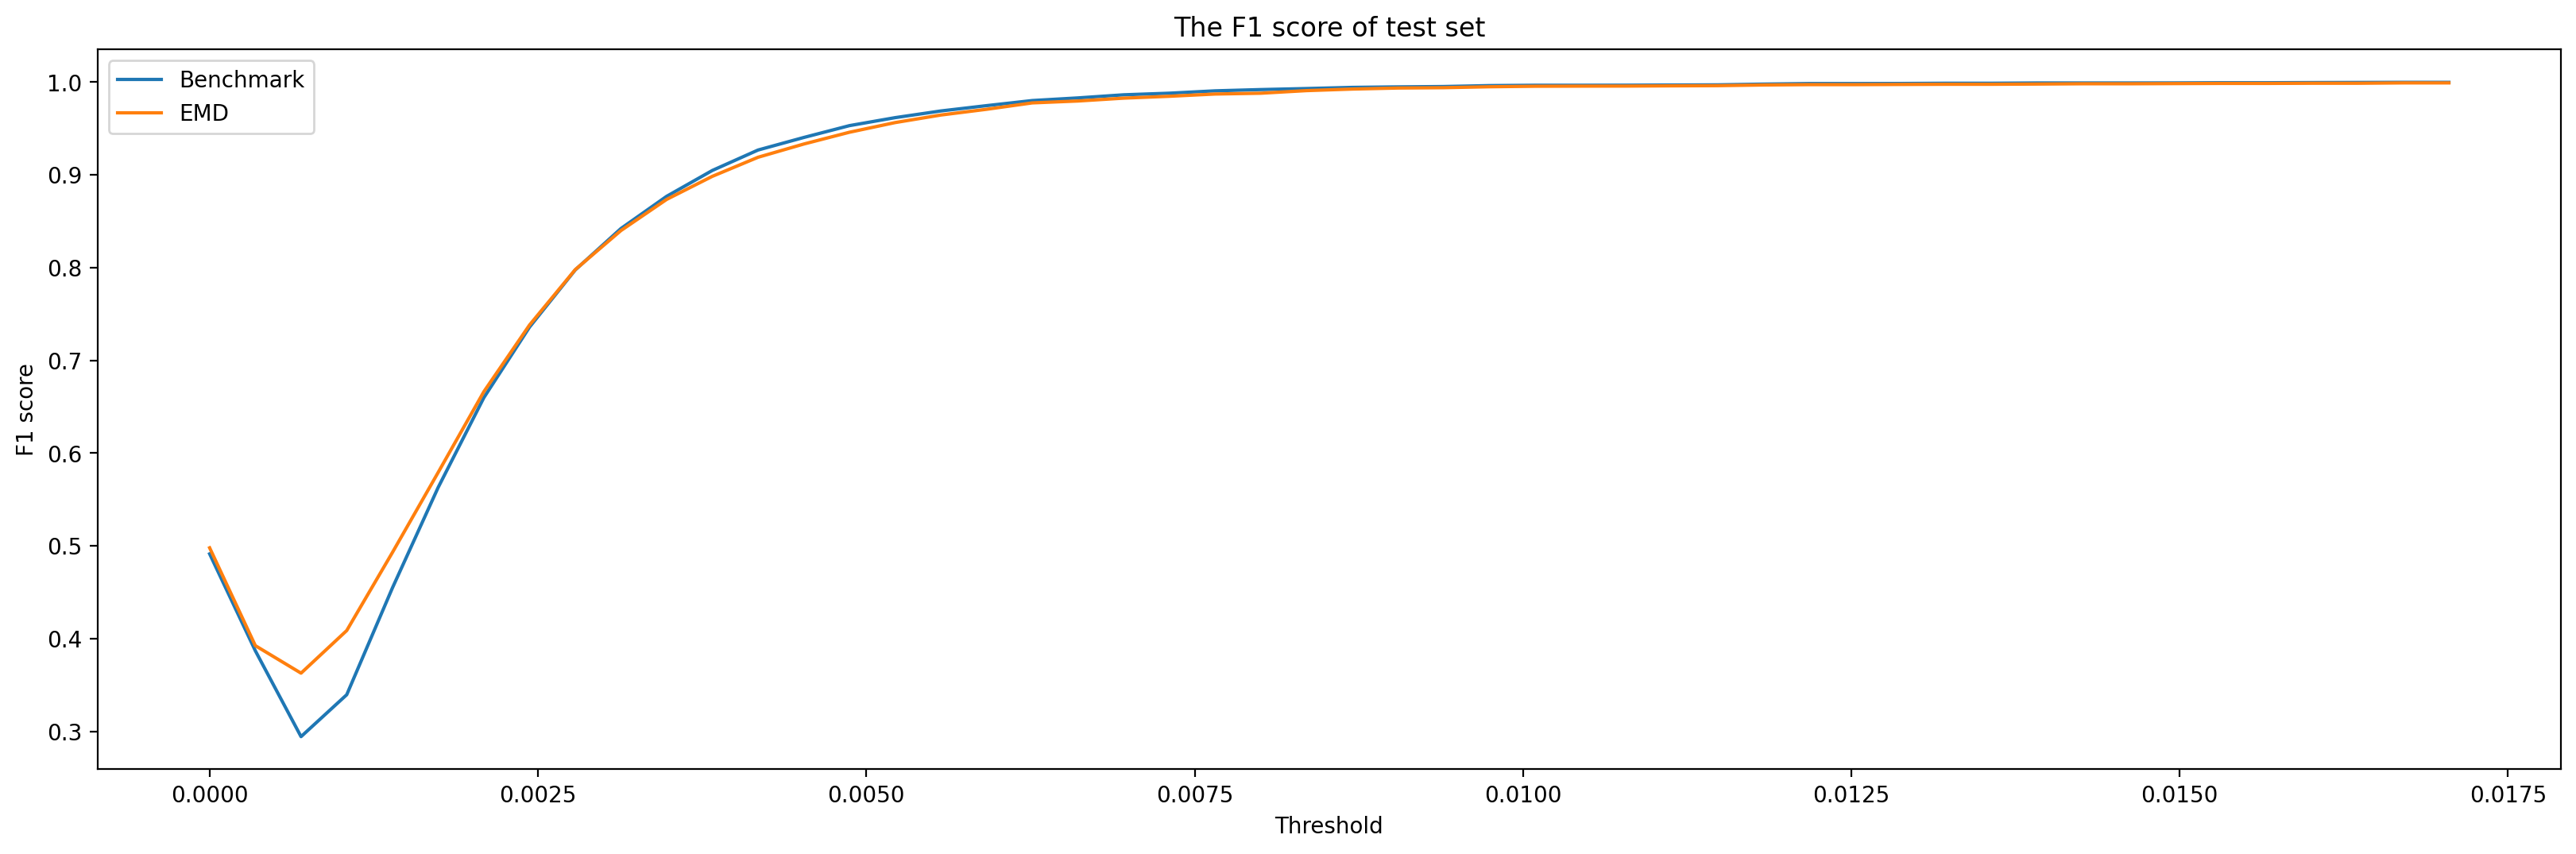

In [87]:
index = pred_range
plt.figure(figsize=(20,6),dpi=200)
plt.plot(index,emd_lst1[:],label = 'Benchmark')
plt.plot(index,emd_lst2[:],label = 'EMD')
plt.ylabel('F1 score')
plt.xlabel('Threshold')
plt.legend()
plt.title('The F1 score of test set')
plt.legend()
plt.savefig("./EMD Classification.jpg")
plt.show()

# CEEMDAN

In [78]:
#the f1-scores line of the model trained by original data and the model trained by the CEEMDAN denoised data
ceemdan_lst1 = []
ceemdan_lst2 = []
count = 0
for i in pred_range:
    print(count)
    a,b = calculate_f1(data,ceemdan_data,i,num)
    ceemdan_lst1.append(a)
    ceemdan_lst2.append(b)
    count = count + 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


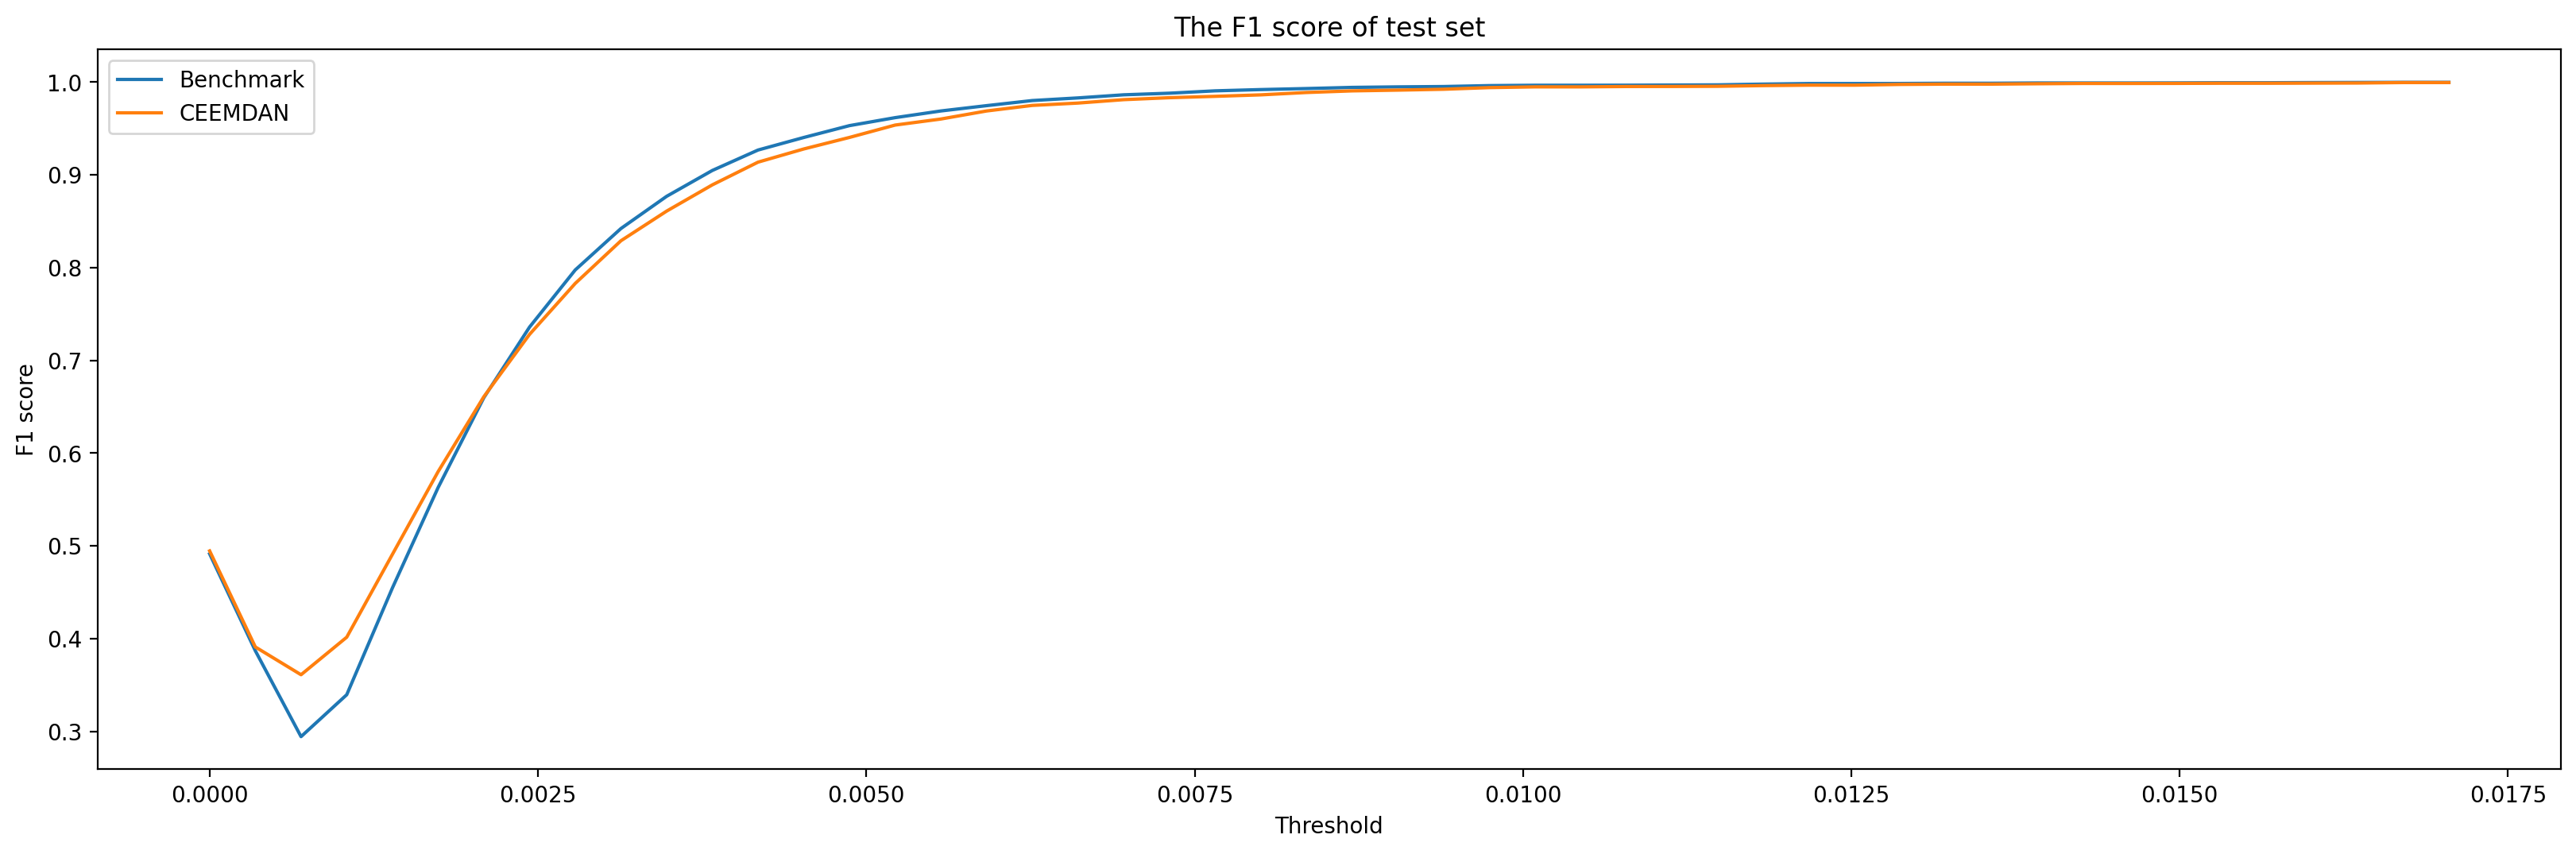

In [88]:
index = pred_range
plt.figure(figsize=(20,6),dpi=200)
plt.plot(index,ceemdan_lst1[:],label = 'Benchmark')
plt.plot(index,ceemdan_lst2[:],label = 'CEEMDAN')
plt.ylabel('F1 score')
plt.xlabel('Threshold')
plt.legend()
plt.title('The F1 score of test set')
plt.legend()
plt.savefig("./CEEMDAN Classification.jpg")
plt.show()

# VMD-DFA

In [80]:
#the f1-scores line of the model trained by original data and the model trained by the VMD-DFA denoised data
vmd_lst1 = []
vmd_lst2 = []
count = 0
for i in pred_range:
    print(count)
    a,b = calculate_f1(data,vmd_data,i,num)
    vmd_lst1.append(a)
    vmd_lst2.append(b)
    count = count + 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


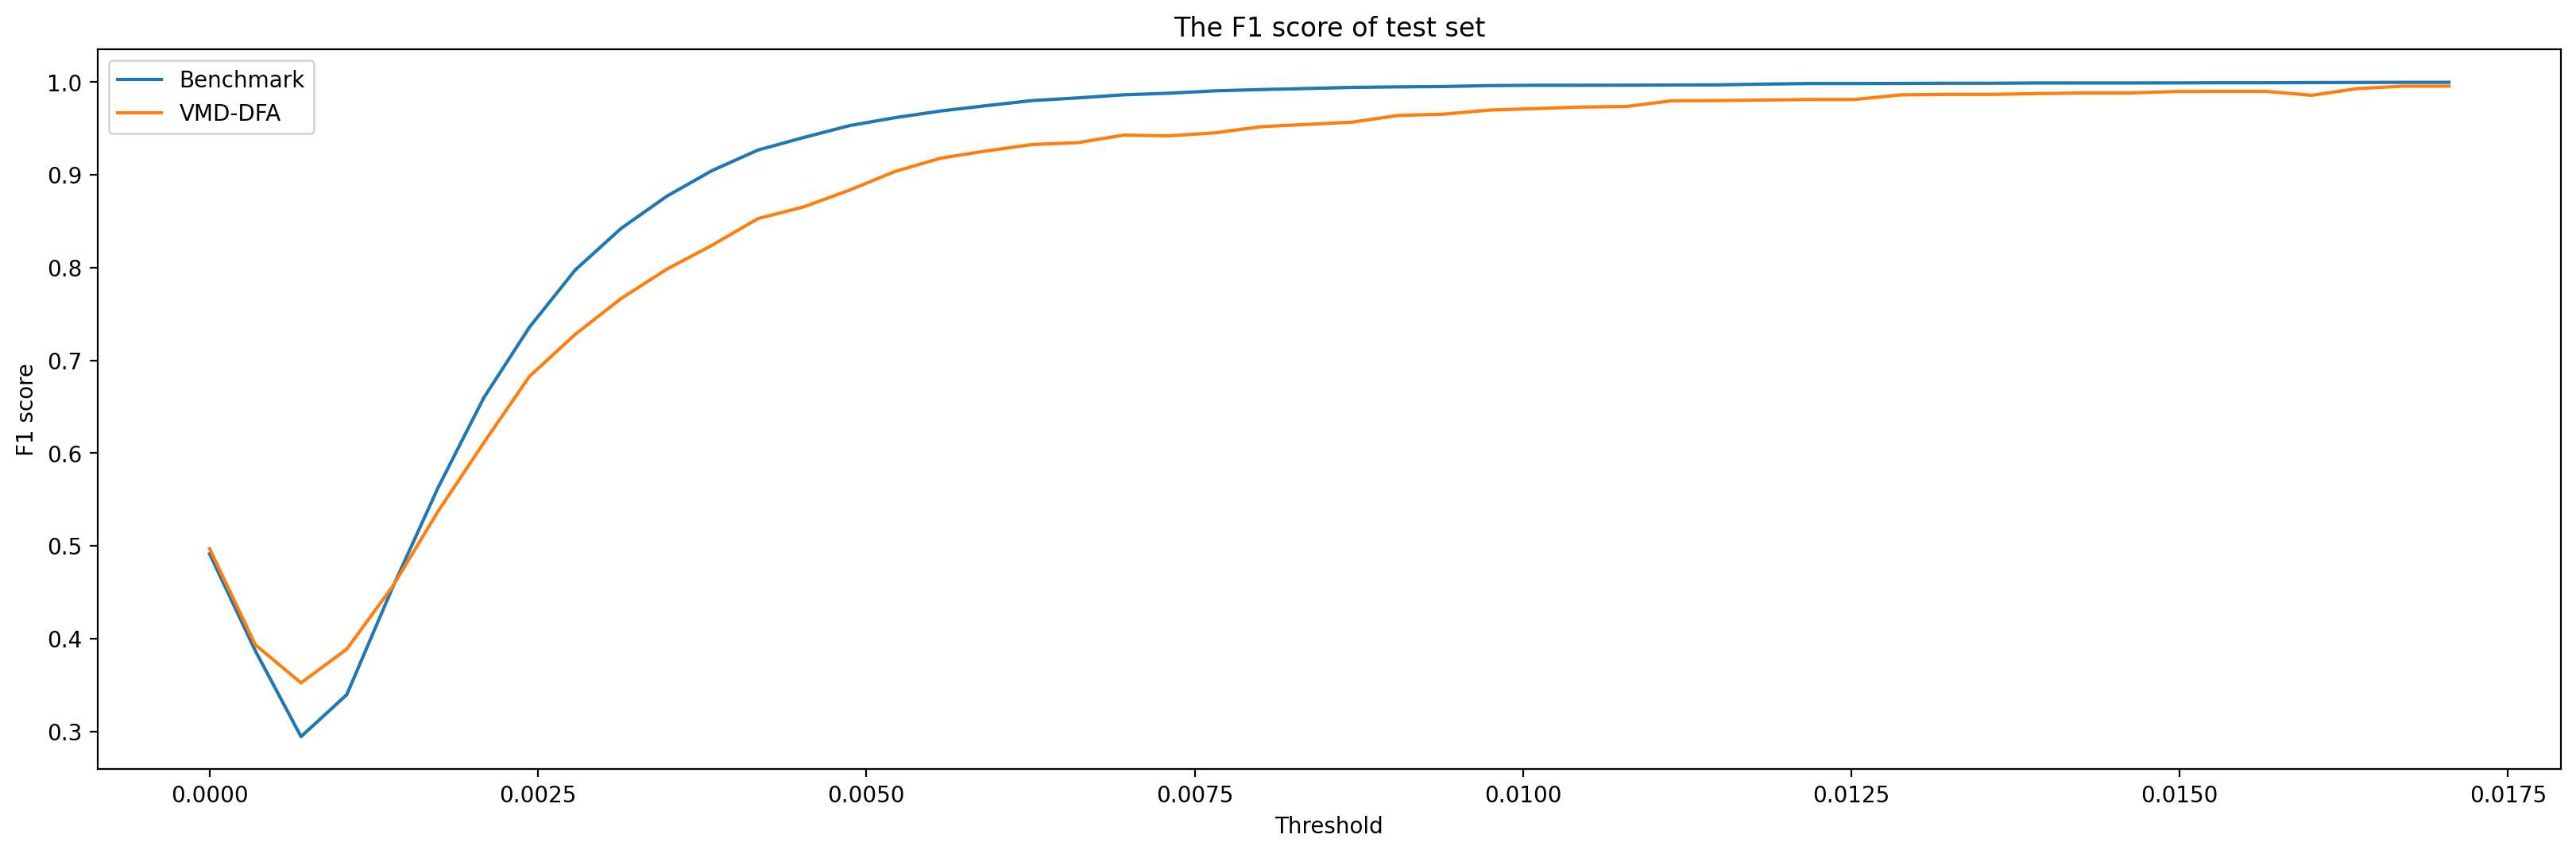

In [89]:
index = pred_range
plt.figure(figsize=(20,6),dpi=200)
plt.plot(index,vmd_lst1[:],label = 'Benchmark')
plt.plot(index,vmd_lst2[:],label = 'VMD-DFA')
plt.ylabel('F1 score')
plt.xlabel('Threshold')
plt.legend()
plt.title('The F1 score of test set')
plt.legend()
plt.savefig("./VMd Classification.jpg")
plt.show()

# VMD-EMD-DFA

In [148]:
#the f1-scores line of the model trained by original data and the model trained by the VMD-EMD-DFA denoised data
vmd_emd_lst1 = []
vmd_emd_lst2 = []
count = 0
for i in pred_range:
    print(count)
    a,b = calculate_f1(data,vmd_emd_data,i,num)
    vmd_emd_lst1.append(a)
    vmd_emd_lst2.append(b)
    count = count + 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


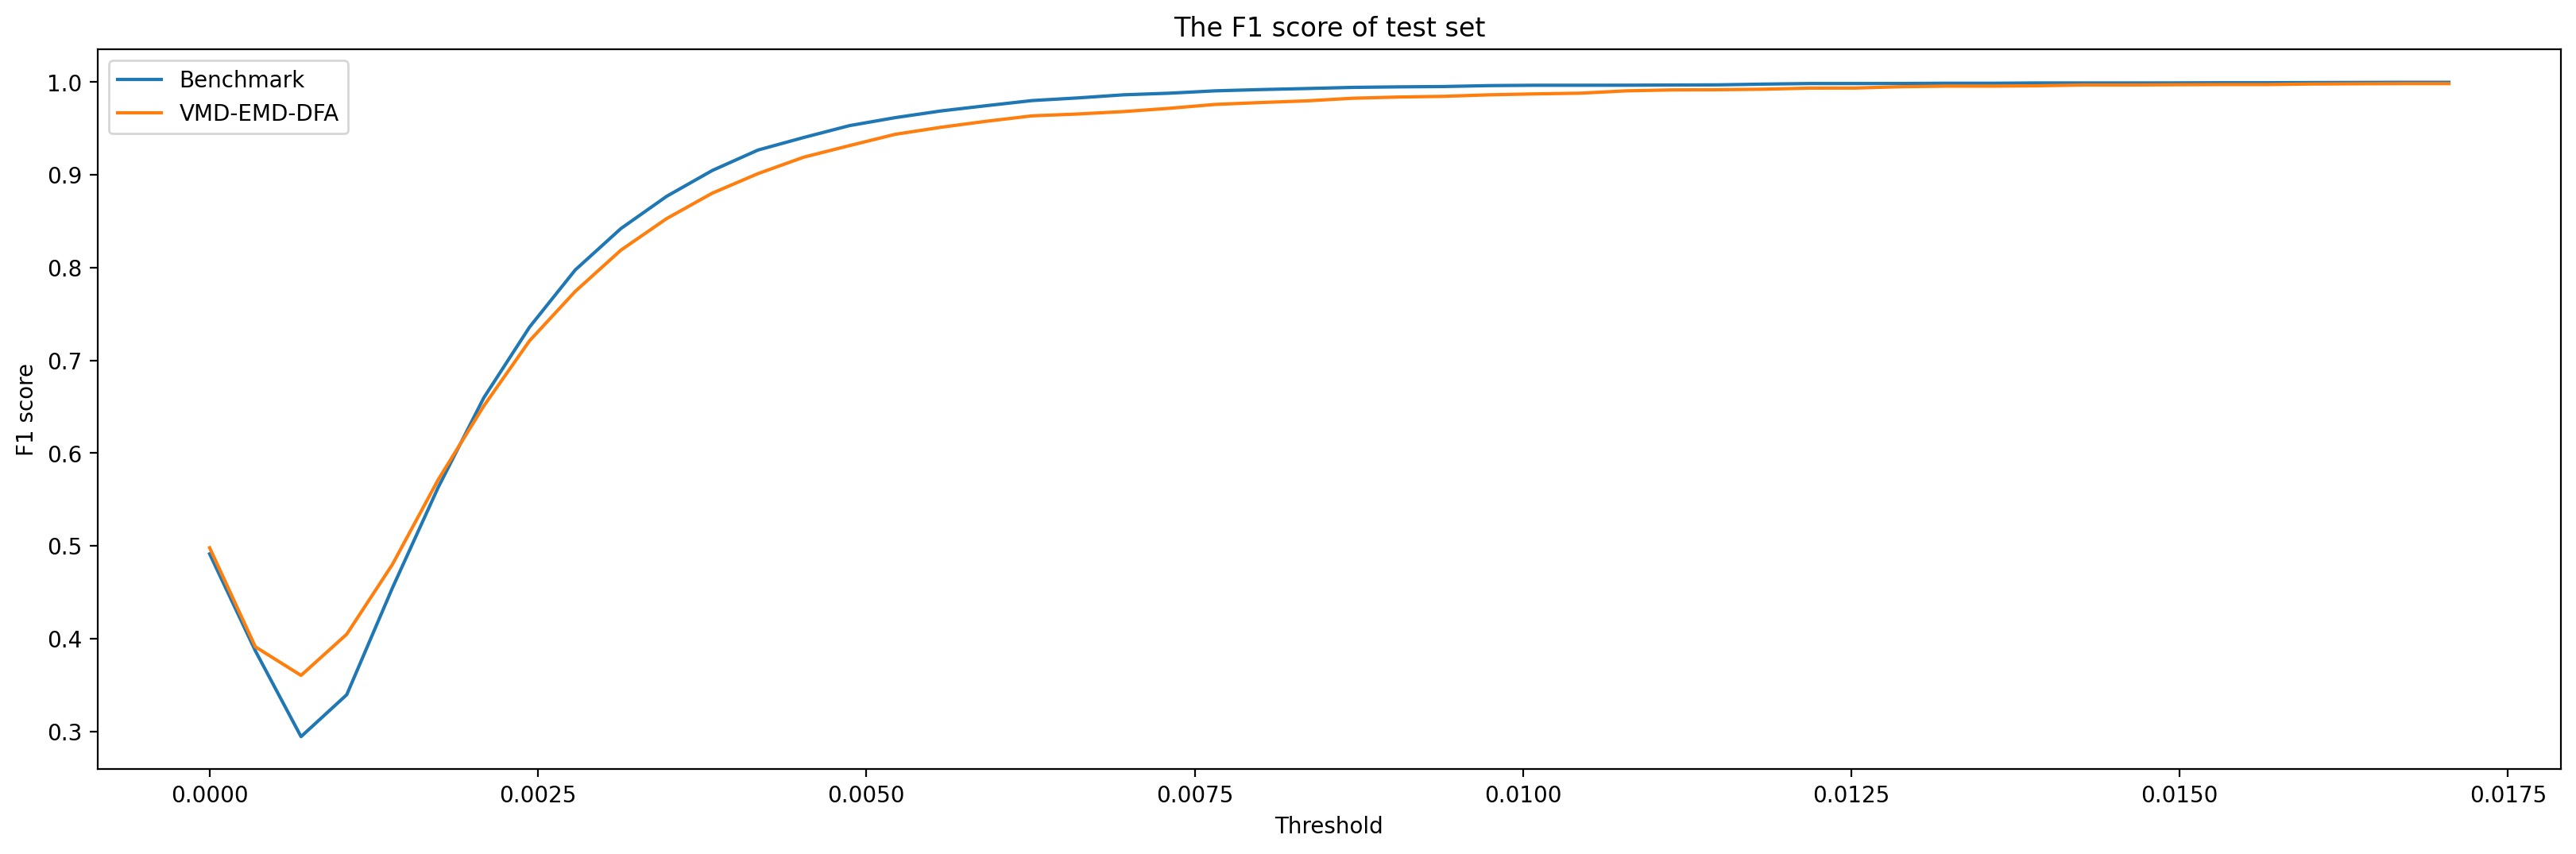

In [149]:
index = pred_range
plt.figure(figsize=(20,6),dpi=200)
plt.plot(index,vmd_emd_lst1[:],label = 'Benchmark')
plt.plot(index,vmd_emd_lst2[:],label = 'VMD-EMD-DFA')
plt.ylabel('F1 score')
plt.xlabel('Threshold')
plt.legend()
plt.title('The F1 score of test set')
plt.legend()
plt.savefig("./VMD emd Classification.jpg")
plt.show()

# plot all

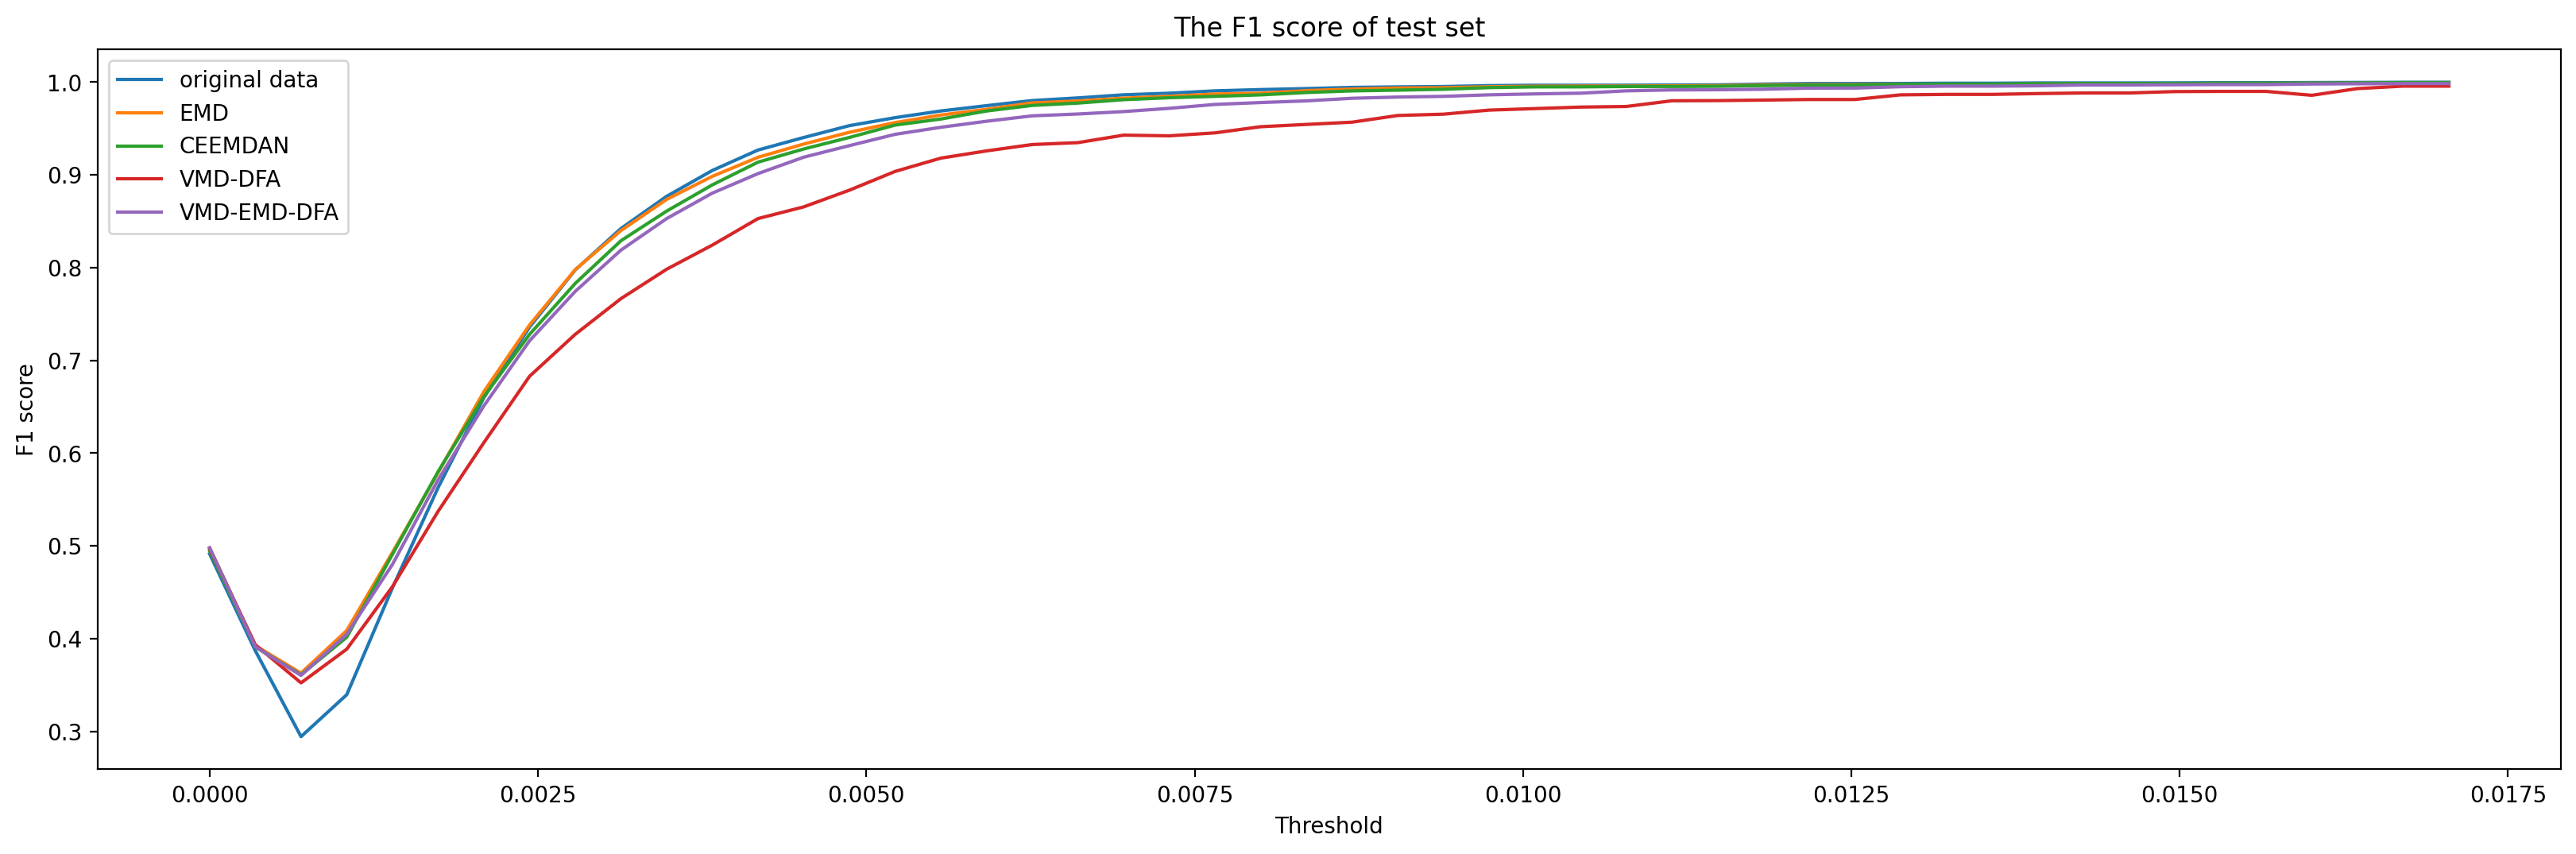

In [150]:
# plot all the f1-scores line of the model trained by original data and the model trained by the denoised data
index = pred_range
plt.figure(figsize=(20,6),dpi=200)
plt.plot(index,ceemdan_lst1[:],label = 'original data')
plt.plot(index,emd_lst2[:],label = 'EMD')
plt.plot(index,ceemdan_lst2[:],label = 'CEEMDAN')
plt.plot(index,vmd_lst2[:],label = 'VMD-DFA')
plt.plot(index,vmd_emd_lst2[:],label = 'VMD-EMD-DFA')
plt.ylabel('F1 score')
plt.xlabel('Threshold')
plt.title('The F1 score of test set')
plt.savefig("./all Classification.jpg")
plt.legend()

plt.show()

# stats

In [93]:
def statistical_tests(series,name): # total version
    adf_test(series)
    print()
    LB_test(series)
    print()
    JB_test(series)
    print()
    plot_acf_pacf(series,name)

In [94]:
# Augmented Dickey-Fuller test (ADF test) for stationarity
def adf_test(series):
    adf_ans = adfuller(series) # The outcomes are test value, p-value, lags, degree of freedom.
    print('ADF Test')
    print('Test value:',adf_ans[0])
    print('P value:',adf_ans[1])
    print('Lags:',adf_ans[2])
    print('1% confidence interval:',adf_ans[4]['1%'])
    print('5% confidence interval:',adf_ans[4]['5%'])
    print('10% confidence interval:',adf_ans[4]['10%'])
    #print(adf_ans) 

In [95]:
# Ljung-Box Test for autocorrelation
def LB_test(series):
    lb_ans = lb_test(series,lags=None,boxpierce=False) #The default lags=40 for long series.
    print('Ljung-Box Test')

    # Plot p-values in a figure
    fig = plt.figure(figsize=(10,3))
    pd.Series(lb_ans.iloc[:,1]).plot(label="Ljung-Box Test p-values")
    plt.xlabel('Lag')
    plt.legend()
    plt.show()
    
    # Brief review
    if np.sum(lb_ans.iloc[:,1])<=0.05: 
        print('The sum of p-value is '+str(np.sum(lb_ans.iloc[:,1]))+'<=0.05, rejecting the null hypothesis that the series has very strong autocorrelation.')
    else: print('Please view with the line chart, the autocorrelation of the series may be not strong.')
    
    # Show the outcome
    # print(pd.DataFrame(lb_ans)) # The outcomes are test value at line 0, and p-value at line 1.

In [96]:
# Jarque-Bera Test for normality
# ------------------------------- 
def JB_test(series=None):
    jb_ans = jb_test(series) # The outcomes are test value, p-value, skewness and kurtosis.
    print('Jarque-Bera Test')
    print('Test value:',jb_ans[0])
    print('P value:',jb_ans[1])
    print('Skewness:',jb_ans[2])
    print('Kurtosis:',jb_ans[3])

    # Brief review
    if jb_ans[1]<=0.05: 
        print('p-value is '+str(jb_ans[1])+'<=0.05, rejecting the null hypothesis that the series has no normality.')
    else:
        print('p-value is '+str(jb_ans[1])+'>=0.05, accepting the null hypothesis that the series has certain normality.')


In [102]:
# Plot ACF and PACF figures
# ------------------------------- 
def plot_acf_pacf(series,name):
    print('ACF and PACF')
    fig = plt.figure(figsize=(10,5))
    fig1 = fig.add_subplot(211)
    plot_acf(series, lags=40, ax=fig1)
    fig2 = fig.add_subplot(212)
    plot_pacf(series, lags=40, ax=fig2)

    #Save the figure
    plt.tight_layout() 
    plt.savefig(name+' ACF and PACF of Series.jpg')
    plt.show()

In [98]:
series1 = data['Close']

ADF Test
Test value: -2.1387860914855823
P value: 0.22920711422488588
Lags: 54
1% confidence interval: -3.430512732170763
5% confidence interval: -2.861611923890369
10% confidence interval: -2.5668082827754803

Ljung-Box Test


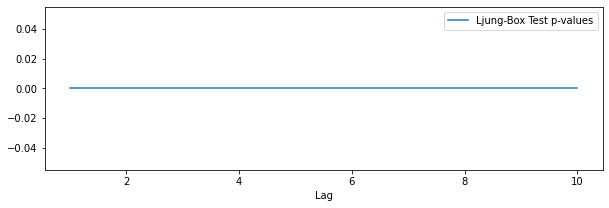

The sum of p-value is 0.0<=0.05, rejecting the null hypothesis that the series has very strong autocorrelation.

Jarque-Bera Test
Test value: 1523.8022339489853
P value: 0.0
Skewness: -0.31391413929980616
Kurtosis: 2.2826333889928003
p-value is 0.0<=0.05, rejecting the null hypothesis that the series has no normality.

ACF and PACF


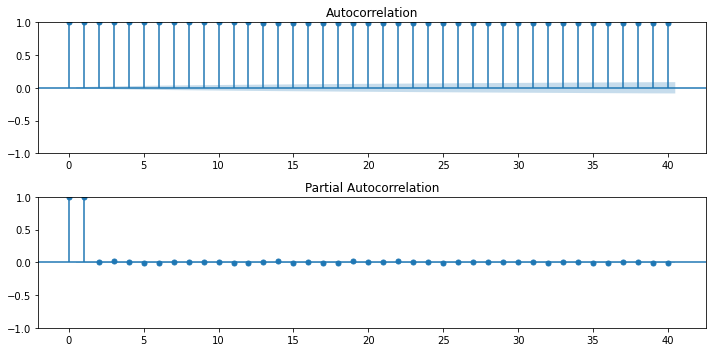

In [103]:
#do statistical tests, including ADF test, LB_test, JB_test, and plot acf and pacf
statistical_tests(series1,"1min bitcoin")

# boxplot

In [152]:
close_df = data[['Close']][:num]

In [153]:
og_denoise_df = pd.DataFrame(index =  data.index[:num] )
og_denoise_df['Benchmark'] = np.log(close_df.iloc[:,0]).diff()

In [154]:
df = pd.DataFrame()
df['reconstructed'] = pd.DataFrame(emd_data)
og_denoise_df['EMD'] = np.log(df.iloc[:,0]).diff()

In [155]:
df = pd.DataFrame()
df['reconstructed'] = pd.DataFrame(ceemdan_data)
og_denoise_df['CEEMDAN'] = np.log(df.iloc[:,0]).diff()

In [156]:
df = pd.DataFrame()
df['reconstructed'] = pd.DataFrame(vmd_data)
og_denoise_df['VMD-DFA'] = np.log(df.iloc[:,0]).diff()

In [157]:
df = pd.DataFrame()
df['reconstructed'] = pd.DataFrame(vmd_emd_data)
og_denoise_df['VMD-EMD-DFA'] = np.log(df.iloc[:,0]).diff()

In [158]:
og_denoise_df

,Benchmark,EMD,CEEMDAN,VMD-DFA,VMD-EMD-DFA
0,NaN,NaN,NaN,NaN,NaN
1,0.000035,0.000036,0.000101,0.000000,0.000000
2,-0.004730,-0.001933,-0.001422,-0.000444,-0.000562
3,-0.000569,-0.001644,-0.001818,-0.000860,-0.001178
4,0.000139,-0.001453,-0.001666,-0.001053,-0.001721
...,...,...,...,...,...
32188,0.003981,0.002433,0.001617,0.000246,-0.000083
32189,0.001966,0.003368,0.002606,0.000506,0.001068
32190,0.000415,0.001861,0.001721,0.000526,0.001839
32191,0.001337,-0.001353,-0.000690,0.000408,0.001892


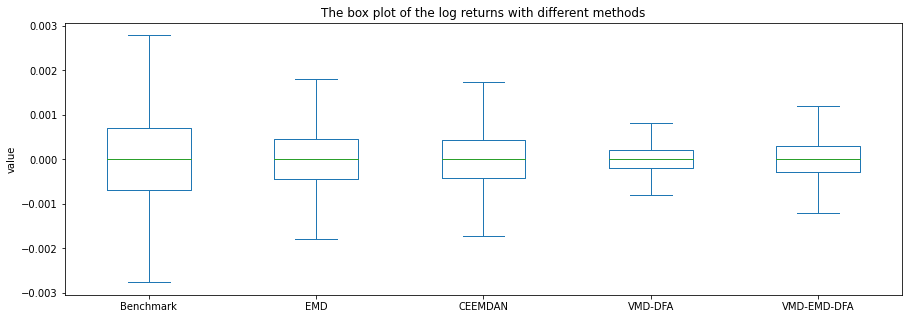

In [172]:
#plot the box of the log returns of the original and the denoised price series
og_denoise_df.iloc[1:,:].plot.box(showfliers=False, title='The box plot of the log returns with different methods', ylabel = 'value',figsize=(15,5))#When using the same y-axis
plt.savefig("./boxplot.jpg")
plt.show()